# Evaluation of Synthetic Time Series with TSGM

Today, we will discuss the evaluation of synthetic datasets -- datasets that are artificially created to represent real data. Let's say there is a synthetic dataset $\hat{D}$ that is aimed at representing a real dataset $D$. It is essential to quantitatively evaluate how good these synthetic data are: Does $\hat{D}$ represent $D$ well? Are these data secure? Are these data valuable for downstream problems? In this tutorial, we'll journey through the methods used to quantitatively and qualitatively assess the quality of synthetic time series data.

First, let's consider two cases from [1] that describe possible usages of synthetic data:

**Scenario 1.** An organization wishes to employ an outside agent to analyze sensitive data or study statistical methods for a given problem. Sharing real data can be complicated due to privacy or commercial concerns. Synthetic counterparts can provide a convenient solution to this problem.

**Scenario 2.** An organization wishes to train a model on a relatively small dataset. However, the dataset is not sufficient for the desired quality of modeling. Such limited datasets can be augmented with synthetic data. This synthetic data, which must be similar to real data, aims to enhance the model’s performance or, in other cases, assist in model reliability tests.

Overall, we indicate and describe in this tutorial the following metrics:
- real data similarity (Sc. 1 and 2),
  * distance metric,
  * discriminative metric,
  * Maximum mean discrepancy score
- predictive consistency (Sc. 1),
- downstream effectiveness (Sc. 2),
- privacy (Sc. 1),
- diversity (Sc. 1 and Sc. 2),
- fairness (Sc. 1),
- visual comparison (Sc. 1 and 2).

We will go throw these metrics, explain them and provide hands-on examples of time series evaluation with TSGM.

In TSGM, all metrics are neatly organized in `tsgm.metrics`. Dive into the details with our comprehensive documentation available at https://tsgm.readthedocs.io/en/latest/modules/root.html#metrics

Now, let's kickstart coding examples by installing tsgm:
```bash
pip install tsgm
```

**Generating synthetic data.** Moving forward, we import tsgm, and load an exemplary dataset. A tensor `Xr` now will contain 100 sine time or constant time series (based on target class `yr`). We will use `(Xr, yr)` as a **real** (=historical=original) dataset. `Xs` contains synthetic data generated by a variational autoencoder. (Note: we use only one epoch for demonstration; increase the number of epochs and check training convergence for practical applications).

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import SVG, display, Image

import numpy as np
import functools
import sklearn
import tensorflow as tf
from tensorflow import keras

import tsgm

2023-12-15 21:20:18.765228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
n, n_ts, n_features = 100, 100, 20
vae_latent_dim = 8

# Load data that will be used as real
Xr, yr = tsgm.utils.gen_sine_vs_const_dataset(n, n_ts, n_features, max_value=2, const=1)
Xr = Xr.astype(np.float32)
yr = keras.utils.to_categorical(yr).astype(np.float32)
ys = yr  # use real labels as synthetic labels

# Using real data generate synthetic time series dataset
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(Xr)
architecture = tsgm.models.zoo["cvae_conv5"](n_ts, n_features, vae_latent_dim)
encoder, decoder = architecture.encoder, architecture.decoder
vae = tsgm.models.cvae.cBetaVAE(encoder, decoder, latent_dim=vae_latent_dim, temporal=False)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(scaled_data, yr, epochs=1, batch_size=64)
Xs, ys = vae.generate(ys)

d_real = tsgm.dataset.Dataset(Xr, yr)
d_syn = tsgm.dataset.Dataset(Xs, ys)

2/2 [==============================] - 5s 97ms/step - loss: 4010.0732 - reconstruction_loss: 3641.8901 - kl_loss: 0.1948


## Real data similarity

### Distance metric

Starting off, it is convenient to measure similarity between real and synthetic data. One approach to doing this is calculate the distance between a vector of summary statistics of synthetic data and real data. $$\text{distance} = \operatorname{Dist}(s(D), s(\hat{D}))$$

The smaller the distance, the closer the synthetic data align with the realism of the actual data. Now, let's define a set of statistics that will serve as the foundation for our distance metric. Methods `tsgm.metrics.statistics.axis_*_s` calculate statistics `*` over the provided axis.

In [3]:
statistics = [
    functools.partial(tsgm.metrics.statistics.axis_max_s, axis=None),
    functools.partial(tsgm.metrics.statistics.axis_min_s, axis=None),
    functools.partial(tsgm.metrics.statistics.axis_max_s, axis=1),
    functools.partial(tsgm.metrics.statistics.axis_min_s, axis=1)]

Moving forward, let us establish the distance metric. For simplicity's sake, we will opt for the Euclidean norm.

In [4]:
discrepancy_func = lambda x, y: np.linalg.norm(x - y)

Bringing it all together, we will utilize `tss.metrics.DistanceMetric` object.

In [5]:
dist_metric = tsgm.metrics.DistanceMetric(
    statistics=statistics, discrepancy=discrepancy_func
)
print(dist_metric(d_real, d_syn))

12.869374


### MMD metric
An alternative approach involves comparing synthetic and real data distributions. In this context, the use of Maximum Mean Discrepancy (MMD) [3] proves to be convenient. MMD serves as a non-parametric two-sample test to determine if samples are drawn from the same distribution. Through empirical observations, we have identified the MMD metric as a particularly convenient method for assessing the similarity of real data.

In [6]:
mmd_metric = tsgm.metrics.MMDMetric()
print(mmd_metric(Xr, Xs))

1.0090577602386475


### Discriminative metric

In this approach, a model is trained to distinguish between real and synthetic data. In TSGM, the tsgm.metrics.DiscriminativeMetric proves to be a valuable tool for this purpose. This metric facilitates the assessment of how effectively a model can discriminate between real and synthetic datasets, providing an additional perspective on data similarity.

In [7]:
# use LSTM classification model from TSGM zoo.
model = tsgm.models.zoo["clf_cl_n"](
    seq_len=Xr.shape[1], feat_dim=Xr.shape[2], output_dim=1).model
model.compile(
    tf.keras.optimizers.Adam(),
    tf.keras.losses.CategoricalCrossentropy(from_logits=False)
)

discr_metric = tsgm.metrics.DiscriminativeMetric()
print(
    discr_metric(
        d_hist=Xr, d_syn=Xs, model=model,
        test_size=0.2, random_seed=42, n_epochs=1
    )
)

2/2 [==============================] - 0s 9ms/step
0.525


## Consistency Metric

Next, we move on to consistency metric. The idea is aligned with **Scenario 1** written above. Here, our focus is on gauging the consistency of a set of downstream models. In more detail, let us consider a set of models $\mathcal{M}$, and an evaluator $E: \mathcal{M} \times \mathcal{D} \rightarrow \mathbb{R}$. 

To evaluate consistency of $\mathcal{M}$ on $D$ and $\hat{D}$, we measure $p(m_1 \sim_{D, \hat{D}} m_2 | m_1, m_2 \in \mathcal{M})$ where $\sim_{D, \hat{D}}$ means if $m_1$ outperforms $m_2$ on $D$ it outperforms $m_2$ on $\hat{D}$ and vice versa. Estimating this probability involves fixing a finite set $\mathcal{M}$ and evaluating the models using real data, and separately evaluating them using synthetic data.

In TSGM, our first step is to define a set of evaluators. For this purpose, we'll leverage a collection of LSTM models, ranging from one to three LSTM blocks.

In [8]:
class EvaluatorConvLSTM():
    '''
    NB an oversimplified classifier, for educational purposes only.
    '''
    
    def __init__(self, model):
        self._model = model

    def evaluate(self, D: tsgm.dataset.Dataset, D_test: tsgm.dataset.Dataset) -> float:
        X_train, y_train = D.Xy
        X_test, y_test = D_test.Xy
        
        self._model.fit(X_train, y_train)
        
        y_pred = np.argmax(self._model.predict(X_test), 1)
        print(self._model.predict(X_test).shape)
        y_test = np.argmax(y_test, 1)
        return sklearn.metrics.accuracy_score(y_pred, y_test)


seq_len, feat_dim, n_classes = *Xr.shape[1:], 2
models = [tsgm.models.zoo["clf_cl_n"](seq_len, feat_dim, n_classes, n_conv_lstm_blocks=i) for i in range(1, 4)]
for m in models:
    m.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
evaluators = [EvaluatorConvLSTM(m.model) for m in models]

Instantiate a consistency metric object using the set of models, and an evaluator wrapper class.

In [9]:
consistency_metric = tsgm.metrics.ConsistencyMetric(evaluators=evaluators)

Last, we measure consistency, using $D$ as the test set. It's worth noting that, in practical scenarios, maintaining a dedicated holdout test set from real data proves beneficial for robust evaluations.

In [10]:
consistency_metric(d_real, d_syn, d_real)

4/4 [==============================] - 0s 14ms/step
(100, 2)
4/4 [==============================] - 0s 27ms/step
(100, 2)
4/4 [==============================] - 0s 42ms/step
(100, 2)
4/4 [==============================] - 0s 17ms/step
(100, 2)
4/4 [==============================] - 0s 30ms/step
(100, 2)
4/4 [==============================] - 0s 43ms/step
(100, 2)


100%|██████████| 3/3 [00:00<00:00, 13812.20it/s]


0.3333333333333333

## Downstream Performance

Now, let's explore how generated data can contribute to improving predictive performance in a specific downstream problem. We'll consider two distinct approaches to evaluating downstream performance:

1. **Augmenting Real Data with Synthetic Data.**
This approach proves valuable when data are limited. By supplementing real data with generated counterparts, we aim to enhance the training set for improved model performance. See our blogpost on data augmentations [here](https://medium.com/@an231/time-series-augmentations-16237134b29b) [2].
2. **Utilizing Generated Data Exclusively for Downstream Model Training.**
In scenarios where real data are scarce and private, this approach comes into play. Here, the downstream model is trained solely on the generated data and subsequently evaluated on real data.

In [11]:
downstream_model = tsgm.models.zoo["clf_cl_n"](seq_len, feat_dim, n_classes, n_conv_lstm_blocks=1).model
downstream_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

evaluator = EvaluatorConvLSTM(downstream_model)

downstream_perf_metric = tsgm.metrics.DownstreamPerformanceMetric(evaluator)

In [12]:
print(downstream_perf_metric(d_real, d_syn, d_real))

4/4 [==============================] - 0s 16ms/step
(100, 2)
4/4 [==============================] - 0s 15ms/step
(100, 2)
-0.12


The result signifies accuracy gain from augmenting with synthetic data compared to the model trained exclusively on the training data.

## Privacy: Membership Inference Attack Metric

Membership inference attack procedure is is visually depicted in the figure below. The idea is the following. Imagine an attacker who has access to synthetic data and a particular data sample (which may or may not exist in the original dataset). The goal is to **infer** whether this sample is present in the real data.

`tsgm.metrics.PrivacyMembershipInferenceMetric` measures the susceptibility to membership inference attacks using synthetic data. The step-by-step evaluation procedure is outlined as follows:   
    1. **Data Splitting.** Split the historical data into training and hold-out sets (denoted as $D_{train}$ and $D_{test}$),  
    2. **Generative Model Training.** Train a generative model on $D_{train}$ and generate a synthetic dataset $\hat{D}$,  
    3. **One-Class Classification (OCC) Model Training.** Train a one-class classification (OCC) model on synthetic data $\hat{D}$ and evaluate it on $D_{tr}$ and $D_{test}$,  
    4. **Target Score Calculation.** Use one minus the precision of the OCC model as the target score.

This evaluation process provides insights into the potential vulnerability to membership inference attacks leveraging synthetic data.

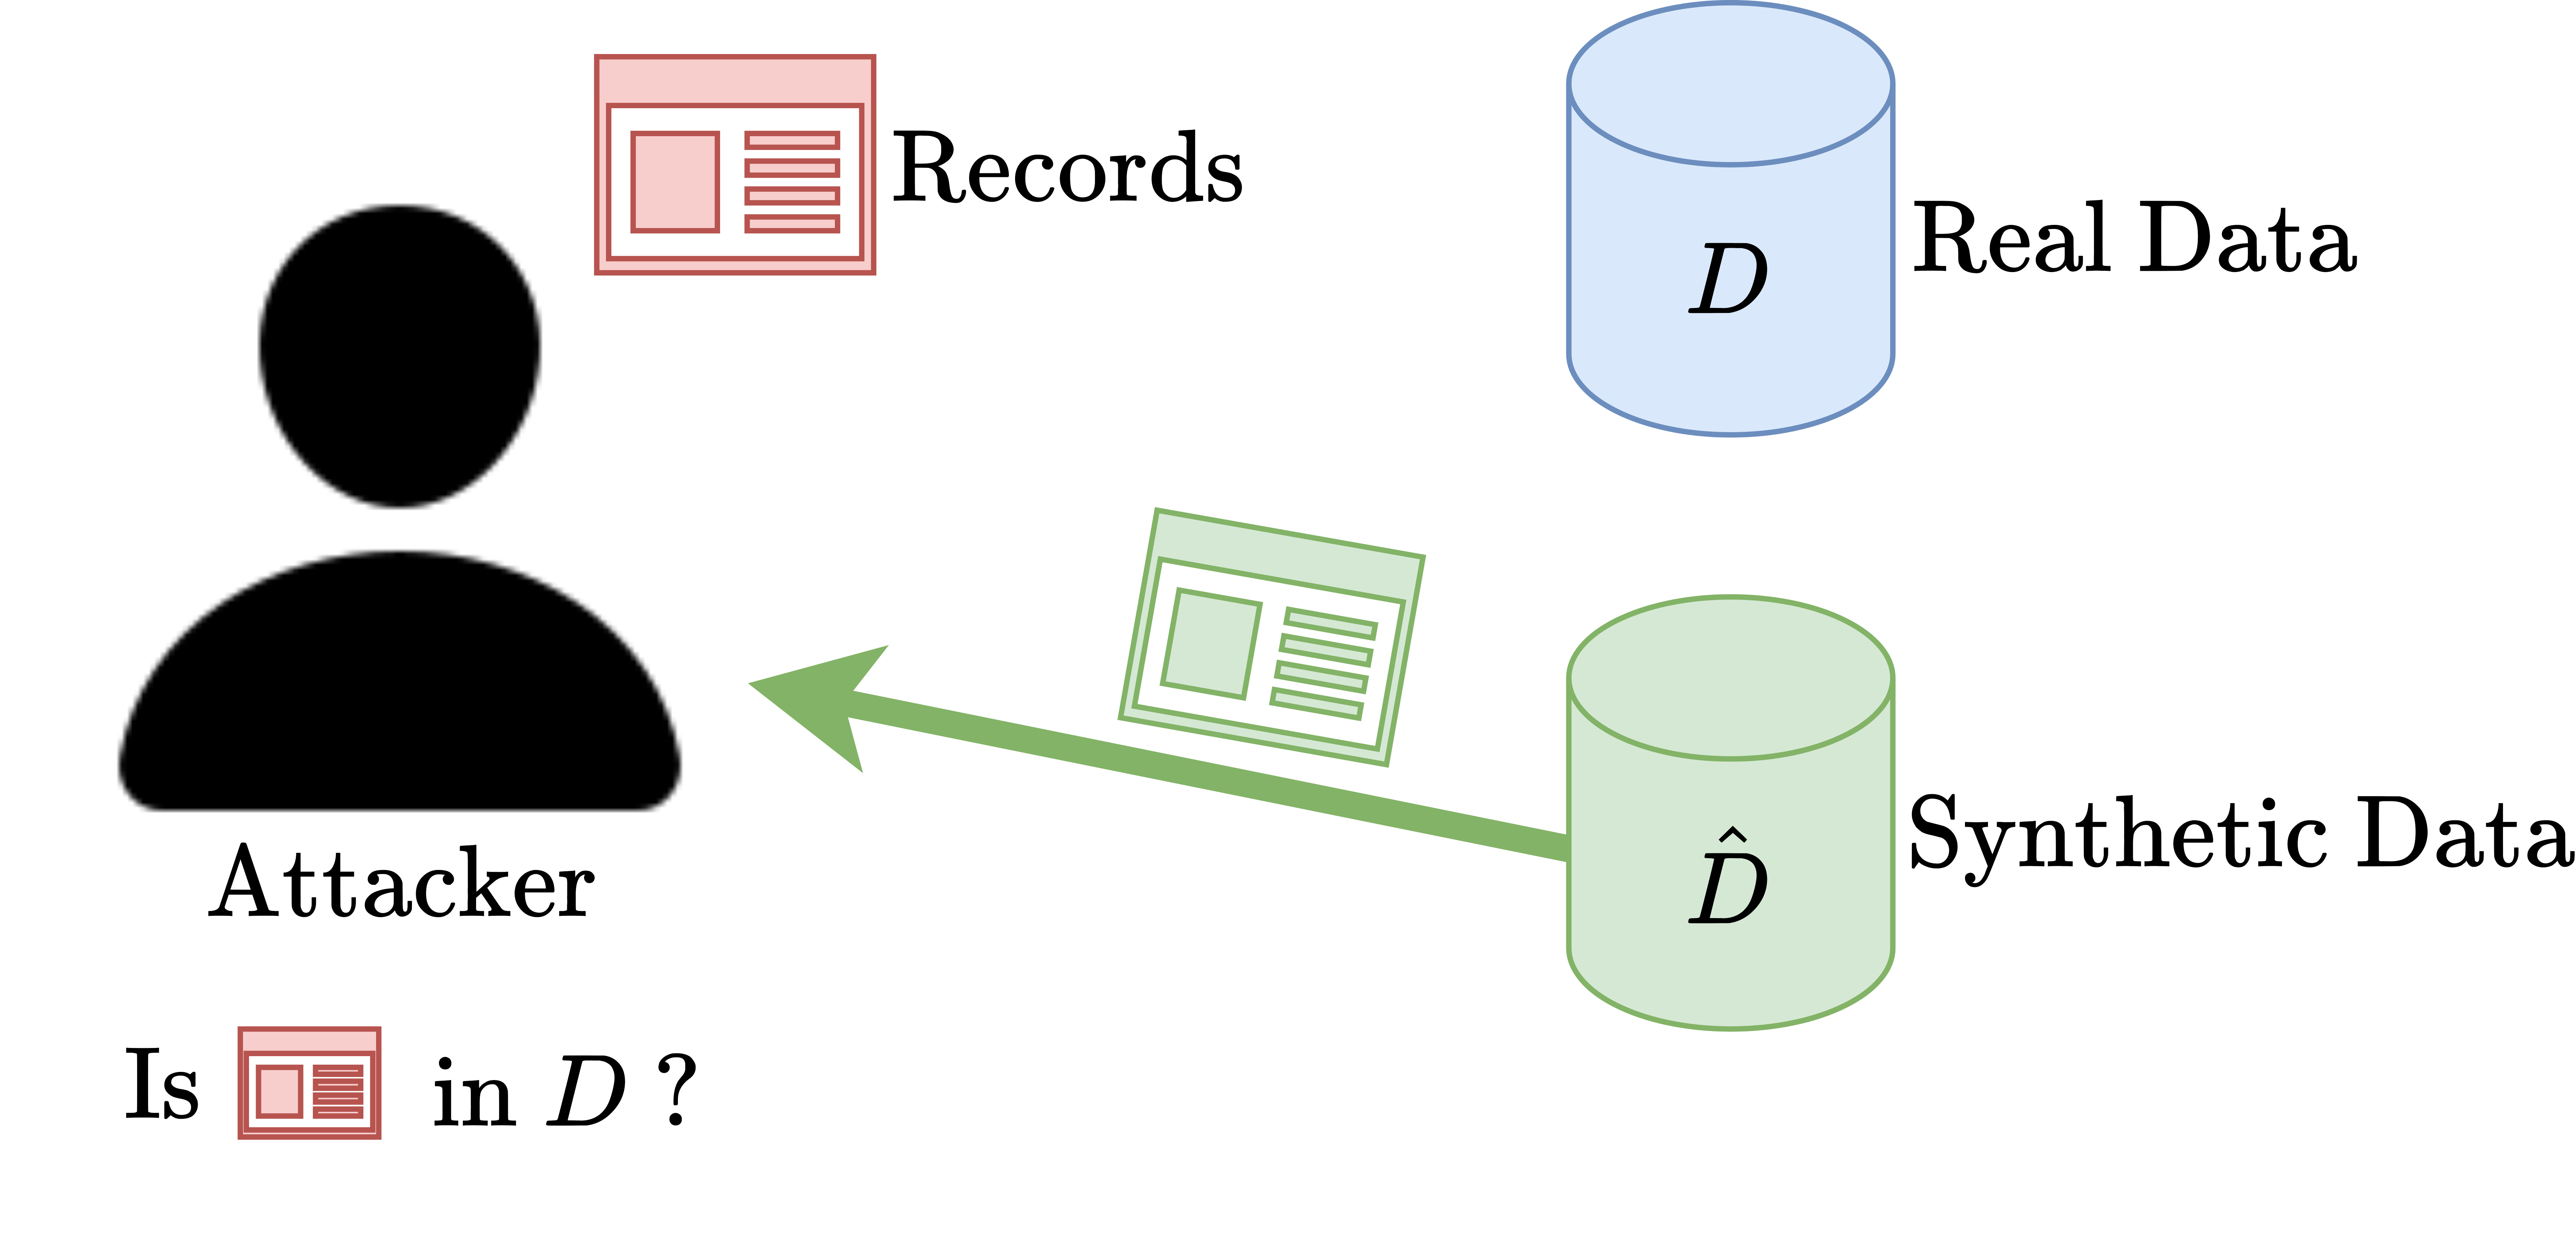

In [13]:
Image("./images/privacy_membership_attack.jpg", height=512, width=512)

Let's now introduce an attacker model. For the sake of demonstration, we'll define a one-class SVM classifier.

In [14]:
class FlattenTSOneClassSVM:
    def __init__(self, clf):
        self._clf = clf

    def fit(self, X):
        X_fl = X.reshape(X.shape[0], -1)
        self._clf.fit(X_fl)

    def predict(self, X):
        X_fl = X.reshape(X.shape[0], -1)
        return self._clf.predict(X_fl)

In [15]:
attacker = FlattenTSOneClassSVM(sklearn.svm.OneClassSVM())
privacy_metric = tsgm.metrics.PrivacyMembershipInferenceMetric(
    attacker=attacker
)

Now, let's define a test set and measure privacy metric:

In [16]:
X_test, y_test = tsgm.utils.gen_sine_vs_const_dataset(10, 100, 20, max_value=2, const=1)
d_test = tsgm.dataset.Dataset(X_test, keras.utils.to_categorical(y_test))

# 1 indicates high privacy and 0 -- low privacy.
privacy_metric(d_real, d_syn, d_test)

1.0

## Diversity
With this metric, our goal is to quantify the diversity of synthetic data. Consider the image below, where red dots represent real data and blue dots signify synthetic data. Which option yields a superior synthetic dataset? The one on the right appears more favorable, but why? The answer lies in its diversity, making it potentially more versatile and useful. However, diversity alone is not sufficient; it's crucial to consider other metrics in tandem, such as distance or downstream performance. In our exploration, we'll exemplify the concept using entropy. 

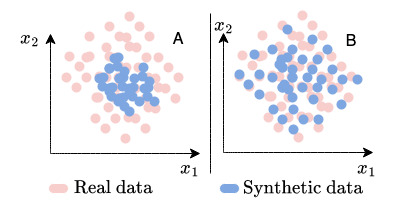

In [17]:
Image("./images/diverse_synthetic_data.jpg", height=512, width=512)

In [18]:
spec_entropy = tsgm.metrics.EntropyMetric()
print(spec_entropy(Xr))
print(spec_entropy(Xs))

/Users/nikitia3/Projects/open_source/tsgm/venv310/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/nikitia3/Projects/open_source/tsgm/venv310/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in true_divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)


302.1819545165017
1790.309182347125


## Fairness

The topic of fairness intersects with synthetic time series generation in two significant ways. Firstly, it's crucial to assess whether synthetic data introduces new biases. Secondly, synthetic data presents an opportunity to mitigate biases inherent in the original data. Defining standardized procedures for checking fairness proves challenging, as it often hinges on the specifics of downstream problems. Some illustrative metrics for measuring fairness encompass demographic parity, predictive rate parity paradigms, and equality of opportunity.

Take for instance, equality of opportunity. Equality of opportunity serves as a fairness metric designed to gauge whether, for a preferred label (one that confers an advantage or benefit to a person) and a given attribute, a classifier predicts that preferred label equally well for all values of that attribute [6]. This metric is instrumental in ensuring impartiality and equal treatment across diverse attribute values. A great example of this metric is provided in [6]: "Suppose Glubbdubdrib University admits both Lilliputians and Brobdingnagians to a rigorous mathematics program. Lilliputians’ secondary schools offer a robust curriculum of math classes, and the vast majority of students are qualified for the university program. Brobdingnagians’ secondary schools don’t offer math classes at all, and as a result, far fewer of their students are qualified. Equality of opportunity is satisfied for the preferred label of "admitted" with respect to nationality (Lilliputian or Brobdingnagian) if qualified students are equally likely to be admitted irrespective of whether they're a Lilliputian or a Brobdingnagian."

## Qualitative analysis

In order to evaluate the data qualitatively it is convenient:
a. draw samples and visualize individual samples from synthetic and real data,
b. build embeddings of the generated samples and visualize them using, for instance, TSNE. Let's examplify (b) with TSGM:

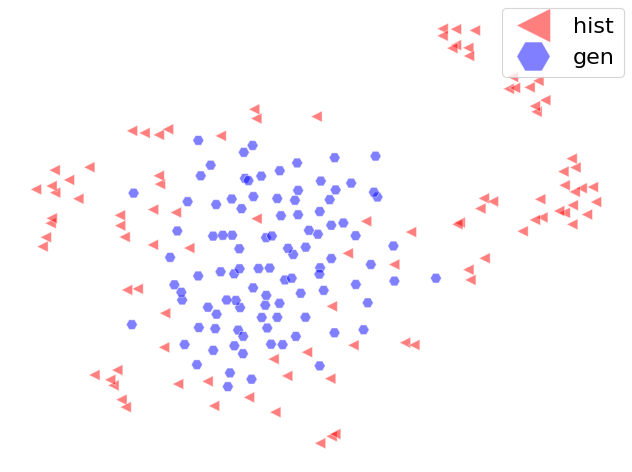

In [19]:
tsgm.utils.visualize_tsne_unlabeled(Xr, Xs, perplexity=10, markersize=100, alpha=0.5)

## Citation

This tutorial is a part of the project TSGM, in which we are creating a tool for enhancing time series pipelines via augmentation and synthetic data generation. If you found it helpful, take a look at our repo and consider citing the paper about TSGM:

```latex
@article{
  nikitin2023tsgm,
  title={TSGM: A Flexible Framework for Generative Modeling of Synthetic Time Series},
  author={Nikitin, Alexander and Iannucci, Letizia and Kaski, Samuel},
  journal={arXiv preprint arXiv:2305.11567},
  year={2023}
}
```

## Conclusion

In conclusion, we've explored various evaluation techniques for synthetic time series data, providing a comprehensive overview of different scenarios. To navigate through these methods effectively, it's beneficial to consider the described scenarios. Ultimately, selecting the right metric is contingent on the downstream problem, application area, and legal regulations governing the data in use. The diverse set of metrics provided aims to assist in crafting a comprehensive evaluation pipeline tailored to your specific problem.

## References:
[1] Nikitin, A., Iannucci, L. and Kaski, S., 2023. TSGM: A Flexible Framework for Generative Modeling of Synthetic Time Series. arXiv preprint arXiv:2305.11567. [Arxiv Link](https://arxiv.org/pdf/2305.11567.pdf)  
[2] Time Series Augmentations, TowardsDataScience post, https://medium.com/towards-data-science/time-series-augmentations-16237134b29b. 
[3] Gretton, A., Borgwardt, K.M., Rasch, M.J., Schölkopf, B. and Smola, A., 2012. A kernel two-sample test. The Journal of Machine Learning Research, 13(1), pp.723-773. [JMLR Link](https://jmlr.csail.mit.edu/papers/v13/gretton12a.html)  
[4] Wen, Q., Sun, L., Yang, F., Song, X., Gao, J., Wang, X. and Xu, H., 2020. Time series data augmentation for deep learning: A survey. arXiv preprint arXiv:2002.12478. [Arxiv Link](https://arxiv.org/pdf/2002.12478.pdf)  
[5] Wattenberg, M., Viégas, F. and Hardt, M., 2016. Attacking discrimination with smarter machine learning. Google Research, 17. [Google Research Link](http://research.google.com/bigpicture/attacking-discrimination-in-ml/)  
[6] Machine Learning Glossary: Fairness. Google Developers Blog.
[Google Developers Blog Link](https://developers.google.com/machine-learning/glossary/fairness)